In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("./Train.csv")
test = pd.read_csv("./Test.csv")

In [3]:
train['Datetime'] = pd.to_datetime(train.Datetime , format = '%Y-%m-%d')
test['Datetime'] = pd.to_datetime(test.Datetime , format = '%Y-%m-%d')

In [4]:
dftest = adfuller(train['DailyMaximumDryBulbTemperature'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -3.400977
p-value                           0.010926
#Lags Used                       16.000000
Number of Observations Used    2859.000000
Critical Value (1%)              -3.432639
Critical Value (5%)              -2.862551
Critical Value (10%)             -2.567308
dtype: float64


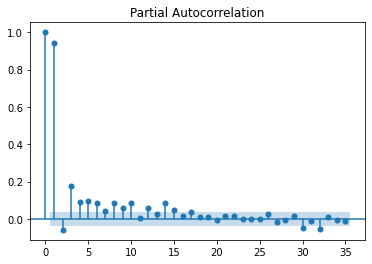

In [5]:
plot_pacf(train['DailyMaximumDryBulbTemperature'])
plt.show()

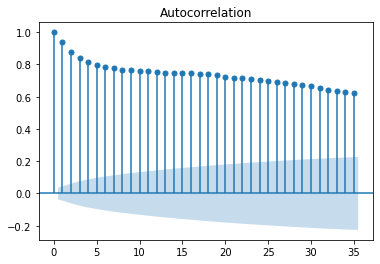

In [6]:
plot_acf(train['DailyMaximumDryBulbTemperature'])
plt.show()

In [7]:
for lag in range(1, 300, 5):
    Max_series = train['DailyMaximumDryBulbTemperature'].iloc[lag:]
    Min_series = train['DailyMinimumDryBulbTemperature'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(Max_series, Min_series))
    print('------')

Lag: 1
(0.7215537426788254, 0.0)
------
Lag: 6
(0.693387567242037, 0.0)
------
Lag: 11
(0.6835506092389929, 0.0)
------
Lag: 16
(0.6758008669459918, 0.0)
------
Lag: 21
(0.6602209274528984, 0.0)
------
Lag: 26
(0.650250983818876, 0.0)
------
Lag: 31
(0.6242277782391626, 3.710820040169282e-307)
------
Lag: 36
(0.5957197663064703, 1.8967298513521954e-272)
------
Lag: 41
(0.5558618019559429, 1.1663885458111224e-229)
------
Lag: 46
(0.5242315693323537, 1.3418065638258747e-199)
------
Lag: 51
(0.49432279439228555, 5.3411426246137265e-174)
------
Lag: 56
(0.4420772009871775, 2.9412518714140805e-135)
------
Lag: 61
(0.4001834058824434, 9.25418690741851e-109)
------
Lag: 66
(0.3449344809014119, 2.5060389152695984e-79)
------
Lag: 71
(0.2977156795000862, 1.6284826987877848e-58)
------
Lag: 76
(0.2421557965613172, 1.192823435047844e-38)
------
Lag: 81
(0.19004691224362968, 3.84941765447805e-24)
------
Lag: 86
(0.13890356967746978, 1.713832470145818e-13)
------
Lag: 91
(0.07954252604027243, 2.640

In [8]:
# Ntrain = np.asarray(train.iloc[:,1])
model = VAR(train[['DailyMaximumDryBulbTemperature','DailyMinimumDryBulbTemperature']])
x =model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,10.13,10.13,2.508e+04,10.13
1,7.245,7.258,1401.,7.250
2,7.203,7.224,1344.,7.211
3,7.163,7.192,1291.,7.173
4,7.153,7.191,1278.,7.167
5,7.144,7.190*,1266.,7.160
6,7.140,7.194,1261.,7.159
7,7.139,7.202,1260.,7.162
8,7.136,7.207,1256.,7.162
9,7.132,7.211,1251.,7.160


In [9]:
lag=300
model_fit = model.fit(lag)
fit_table=model_fit.fittedvalues

In [10]:
print(model_fit.y[0][1])

16.0


In [11]:
prediction = model_fit.forecast(model_fit.y, steps=len(test))
prediction

array([[63.8088675 , 15.98805873],
       [65.20336909, 16.78607296],
       [63.051258  , 22.6851598 ],
       ...,
       [61.23525244, 26.7057784 ],
       [60.61373319, 26.56912069],
       [60.2080229 , 26.29190179]])

In [12]:
prediction.shape

(720, 2)

In [13]:
df = pd.DataFrame(prediction,columns = ['DailyMaximumDryBulbTemperature','DailyMinimumDryBulbTemperature'])

In [14]:
df['Datetime'] = pd.date_range(start='2018/11/16',end='2020/11/4')

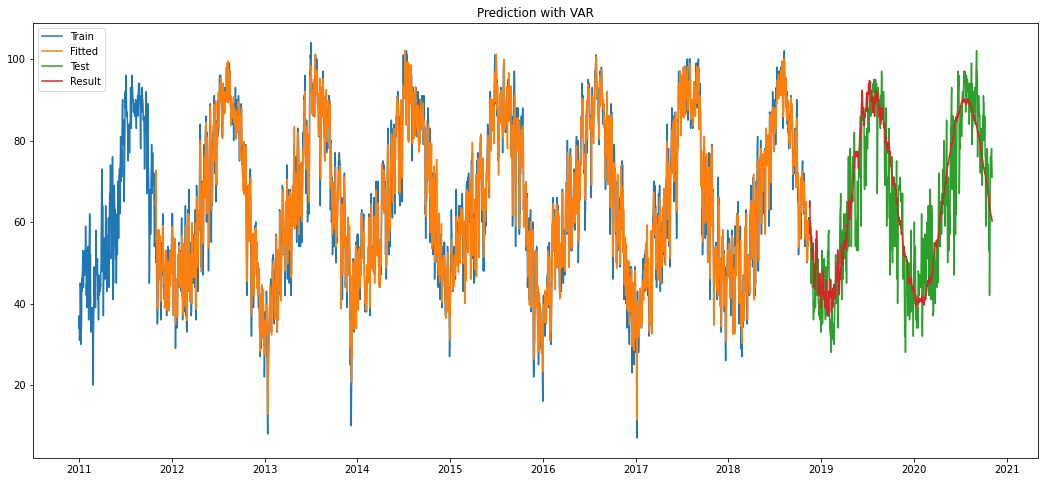

In [15]:
plt.figure(figsize=(18,8))
plt.plot(train.Datetime, train['DailyMaximumDryBulbTemperature'], label='Train')
plt.plot(train.Datetime[lag:], fit_table['DailyMaximumDryBulbTemperature'], label='Fitted')
plt.plot(test.Datetime, test['DailyMaximumDryBulbTemperature'], label='Test')
plt.plot(df.Datetime, df['DailyMaximumDryBulbTemperature'],  label='Result')
plt.legend(loc='best')
plt.title('Prediction with VAR')
# plt.savefig('./res.png')
plt.show()

In [16]:
mse = mean_squared_error(test.DailyMaximumDryBulbTemperature, df.DailyMaximumDryBulbTemperature)
rmse = sqrt(mean_squared_error(test.DailyMaximumDryBulbTemperature, df.DailyMaximumDryBulbTemperature))
mse,rmse

(87.05385913297692, 9.330265758968332)

In [22]:
mse = mean_squared_error(test.DailyMinimumDryBulbTemperature, df.DailyMinimumDryBulbTemperature)
rmse = sqrt(mean_squared_error(test.DailyMinimumDryBulbTemperature, df.DailyMinimumDryBulbTemperature))
mse,rmse

(61.76442807931456, 7.859034805834274)

In [17]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 03, Apr, 2021
Time:                     23:21:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.2433
Nobs:                     2576.00    HQIC:                   8.50196
Log likelihood:          -15783.5    FPE:                    1861.78
AIC:                      7.51178    Det(Omega_mle):         1224.01
--------------------------------------------------------------------
Results for equation DailyMaximumDryBulbTemperature
                                         coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------
const                                      17.737109         4.529522            3.916           0.000
L1.DailyMaximumDryBulbTemperature           0.9212